# 3D Geometric Model of Inflated Dunnage Bag - Reduction in Void

## Assumptions:

1. Material is rigid
2. Idealized geometry
3. Not rate dependent
4. Mass is constant
5. Temperature has no effect on the material or the inflated air

## Import Libraries:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
from scipy.interpolate import spline
from math import pi #import pi function for simple reference

## Functions:

In [2]:
#Find volume from length, width and diameter
def updateVolume(width,length,diameter):
    LengthLong = width - float(pi*diameter)/2 
    AreaLong = diameter*LengthLong + float(pi*diameter**2)/4
    LengthShort = length - float(pi*diameter)/2
    AreaShort = diameter*LengthShort + float(pi*diameter**2)/4
    VolumeSphere = float(1/6)*(diameter**3)*(pi)
    return (AreaLong*LengthShort) + (AreaShort*LengthLong) + VolumeSphere

In [3]:
#Update the Pressure using Ideal Gas Law
def updatePressure(mass,volume):
    return mass*8.3144598*298.15/volume

In [4]:
#Get the mass using the Ideal Gas Law (ABSOLUTE PRESSURE)
def updateMass(pressure,volume):
    return((101500-pressure) *volume)/(8.3144598*298.15)

In [5]:
#Get stess from Barlow's formula
def updateStress(diameter,pressure): 
    return (diameter*(pressure))/(2*1)

In [6]:
#Find the new length using the strain calculated
def updateLength(length,strain):
    ChangeInLength = length*strain 
    return length+ChangeInLength

In [7]:
#Get strain from stress-strain curve
def getStrain(stress,strain,stress_barlow):
    index = np.array(stress).searchsorted(stress_barlow)#find index from barlow's stress value
    x2 = strain[index-1] #find strain value to left
    x1 = strain[index] #find strain value to right
    y2 = stress[index-1] #find stress value to left
    y1 = stress[index] #find stress value to right
    return x1 + (stress_barlow-y1)*(x2 - x1)/(y2 - y1)

In [8]:
#Get new void size (new diameter), using Barlow Formula (RELATIV PRESSURE)
def updateDiameter(stress,pressure): 
    return 2*stress*1/(pressure)    

## Import Data for Stress-Strain:

In [9]:
def StressStrainData():
    textfile =  'C:\\Users\\Inance\\Documents\\Thesis\\Mathematical_Model\\MATHEMATICAL_MODEL_OUTPUT_FILES\\average_tensile_7threads_warp.txt'
    with open(textfile,'r') as file:
        lst = [] 
        for line in file:
            lst.append([ float(x) for x in line.split()])
        force = np.array([ x[0] for x in lst])
        stress =(np.array([ x[1] for x in lst]))
        stress = (stress)*100
        strain =np.array([ x[2] for x in lst])
        time =np.array([ x[3] for x in lst])
    return force, stress, strain, time

In [10]:
force, sig, eps, time = StressStrainData()

## Input Parameters - Main A:

In [11]:
#Constants:
w=0.9
d=0.5
l=[1.5] #initial length

#Initial values:

P=[20000]  #initial GAUGE pressure (20 kPa)
V=[1]
m=[updateMass(P[0],V[0])] #initial mass from Ideal Gas Law
sig_b = [updateStress(d,P[0])] #initial stress form Barlows
epsa = [0.0]

#print ('sig =',sig,'\n','eps =',eps,)
print ('\n','P =',P,'\n','V =',V,'\n','m =',m,'\n','sig_b =',sig_b)

# Main A - loop parameters:
max_iter = 20 #maximum number of iterations
m_tol = 0.0005 #mass tolerance
i = 0 #starting number of iteration
m_diff = 10.0 #
m_old = 100 #old mass 


 P = [20000] 
 V = [1] 
 m = [32.87674076269672] 
 sig_b = [5000.0]


## Main A - Just Inflated:

In [12]:
print("{0}      {1}       {2}          {3}          {4}          {5}".format("P","epsa","l","V","m","sig_b"))
while (m_diff >= m_tol and i < max_iter):
    P.append(P[0]) #update Pressure
    
    sig_b.append(updateStress(d,P[i+1])) #get Stress using Barlow's formula, GAUGE PRESSURE
    
    epsa.append(getStrain(sig,eps,sig_b[i+1])) #call Strain function
    
    l.append(updateLength(l[0],epsa[i+1]))#get updated length
    
    V.append(updateVolume(w,l[i+1],d)) #get Volume
    
    m.append(updateMass(P[i+1],V[i+1])) #initial mass from Ideal Gas Law, ABSOLUTE PRESSURE
    
    #Loop constraints
    m_diff = np.abs(m[i+1] - m_old) #calculate abs difference between old m and new m
    m_old = m[i+1] #set the old m equal to the current m for the next loop
    
    print("{0}  {1:.6f}   {2:.6f}   {3:.6f}   {4:.6f}  {5}".format(P[i+1],epsa[i+1],l[i+1],V[i+1],m[i+1],sig_b[i+1]))

    i+=1 #increment i to loop ,V,m,sig_b

P      epsa       l          V          m          sig_b
20000  0.025285   1.537927   0.321952   10.584723  5000.0
20000  0.025285   1.537927   0.321952   10.584723  5000.0


## Import Single Cycle Full Scale Bag Data:

In [13]:
def CyclicBagData():
    textfile = 'C:\\Users\\Inance\\Documents\\Thesis\\Mathematical_Model\\MATHEMATICAL_MODEL_OUTPUT_FILES\\average_single_cycle.txt'
    with open(textfile,'r') as file:
        lst = [] 
        for line in file:
            lst.append([ float(x) for x in line.split()])
        time = np.array([ x[0] for x in lst])
        void =(np.array([ x[1] for x in lst]))
        void = (void)*0.001
        pressure =np.array([ x[2] for x in lst])
        pressure = (pressure)*100000
    return time,void,pressure

In [14]:
def getNumber(specific_list,position):
    specific_list=specific_list.tolist()
    if position%2==0: #even numbers
        IndexPosition = specific_list.index(min(specific_list)) #void size is lowest
    else: #uneven number
        IndexPosition = specific_list.index(max(specific_list)) #void size is highest
    return specific_list[IndexPosition]

In [15]:
def getIndex(specific_list,position):
    specific_list=specific_list.tolist()
    if position%2==0:
        IndexPosition = specific_list.index(min(specific_list))
    else:
        IndexPosition = specific_list.index(max(specific_list))
    return IndexPosition 

In [16]:
#Import Single Cycle Burst Data:
Cyclic_Time,Cyclic_Void,Cyclic_Pressure = CyclicBagData()

#Look at specific max-to-min void reduction list:
void_start = Cyclic_Void[(getIndex(Cyclic_Void,1)):] #cut off starting values before max
void_final = void_start[:(getIndex(Cyclic_Void,2))] #cut off final value after min, final single cycle void list
#print(void_final)

#Look at specific max-to-min void reduction list:
pressure_start = Cyclic_Pressure[(getIndex(Cyclic_Void,1)):] #cut off starting values before max
pressure_final = pressure_start[:(getIndex(Cyclic_Void,2))] #cut off final value after min, final single cycle void list
#print(pressure_final)

print(len(void_final),len(pressure_final))

380 380


## Input Parameters - Main B:

In [17]:
#Loop parameters:
max_iter = 400
k = 0 #number of iterations
l_tol = 0.0005
l_diff = 10.0
l_old = 100
list_size=1

#Input parameters for Main B:
d_red=np.empty((list_size, 0)).tolist()
d_red[0] = void_final[0]

P_red=np.empty((list_size, 0)).tolist()
P_red[0] = pressure_final[0] #diameter which is reduced
P_ideal=np.empty((list_size, 0)).tolist()
P_ideal[0] = P[2] #end pressure of Main A, starting pressure for Main B


m_red = [m[2]] #end mass of Main A, starting mass for Main B
V_red = [V[2]] #end volume of Main A, starting volume for Main B

sig_b_red = [sig_b[2]] #end barlow stress of Main A, starting barlow stress for Main B
epsa_red = [epsa[2]] #end strain of Main A, starting strain for Main B
l_red = [l[2]] #end length of Main A, starting length for Main B
print(d_red[0],'\t',P_red[0],'\t',epsa_red[0],'\t',V_red[0],'\t',sig_b_red[0])

0.305199883333 	 12030.0 	 0.0252845891583 	 0.321951707109 	 5000.0


## MAIN - Time loop:

In [18]:
t_max_index = getIndex(Cyclic_Void,1) #time start
t_min_index = getIndex(Cyclic_Void,2) #time end
t_length = (Cyclic_Time.tolist()[t_min_index] - Cyclic_Time.tolist()[t_max_index]) #nr of data points in interested timeline
#t_length = int((Cyclic_Time.tolist()[t_min_index] - Cyclic_Time.tolist()[t_max_index])/0.02) #nr of data points in interested timeline
#time_relevant = [x * 0.02 for x in range(t_length)] #generate relevant time list
print(t_length,t_length/0.02)
t=0

7.220000000000001 361.0


## Main B - Reduction in Void:

In [19]:
print("{0}      {1}      {2}          {3}        {4}   {5}      {6}      {7}".format("t","d_red","P_red","P_ideal","epsa_red","V_red","l_red","sig_b_red"))

while t <= t_length and k < max_iter:
    
    V_red.append(updateVolume(w,l_red[k],d_red[k])) #get VOLUME from idealized geometry

    P_ideal.append(updatePressure(m_red[0],V_red[k+1])) #get PRESSURE from ideal gas law
    
    P_red.append(pressure_final[k+1]) #get PRESSURE from experimental data

    sig_b_red.append(updateStress(d_red[k],P_red[k])) #get STRESS from barlow's formula
    
    epsa_red.append(getStrain(sig,eps,sig_b_red[k+1]))#get STRAIN from experimental stress-strain curve
    
    l_red.append(updateLength(l_red[0],epsa_red[k+1]))#get NEW LENGTH from strain formula
    
    d_red.append(void_final[k+1])#get actual DIAMETER from experimental data
    
    #Loop constraints
    l_diff = np.abs(l_red[k+1] - l_old) #calculate abs difference between old V and new V
    l_old = l_red[k+1] #set the old V equal to the current V for the next loop
    
    print("{0:.2f}   {1:.6f}   {2:.6f}   {3:.6f}   {4:.6f}   {5:.6f}   {6:.6f}   {7:.6f}".format(t,d_red[k],P_red[k+1],P_ideal[k+1],epsa_red[k+1],V_red[k+1],l_red[k+1],sig_b_red[k+1]))
    k+=1 #increment k to loop 
    t+=0.02

t      d_red      P_red          P_ideal        epsa_red   V_red      l_red      sig_b_red
0.00   0.305200   12025.000000   66453.740666   0.007390   0.394847   1.549292   1835.777298
0.02   0.305195   12022.500000   65828.778715   0.007387   0.398596   1.549287   1834.983084
0.04   0.305193   12027.500000   65829.053760   0.007385   0.398594   1.549285   1834.591962
0.06   0.305190   12035.000000   65829.234587   0.007388   0.398593   1.549289   1835.333997
0.08   0.305188   12037.500000   65829.031017   0.007392   0.398594   1.549296   1836.468379
0.10   0.305188   12037.500000   65828.675117   0.007394   0.398596   1.549298   1836.850425
0.12   0.305188   12037.500000   65828.554549   0.007394   0.398597   1.549298   1836.850867
0.14   0.305188   12045.000000   65828.553765   0.007394   0.398597   1.549298   1836.851098
0.16   0.305188   12060.000000   65828.553384   0.007398   0.398597   1.549304   1837.995663
0.18   0.305192   12070.000000   65828.134143   0.007407   0.398600   1.

## Iteration Graphs:

In [20]:
#Create Figures
axis_font = {'size':'12'} #customize graph
def CreateGraphs(x_list,y_list,name_x,name_y,i):
    fig = plt.figure(figsize=(7,25)) 
    ax = fig.add_subplot(7,1,i)
    ax.plot(x_list, y_list) #create a scatter plot
    plt.ylabel(name_x,**axis_font),plt.xlabel(name_y,**axis_font) #name axes
    plt.show() #show graph
    #fig.savefig(path.join(outpath,"{0}_vs_{1}.png".format(name_x,name_y)))
    return

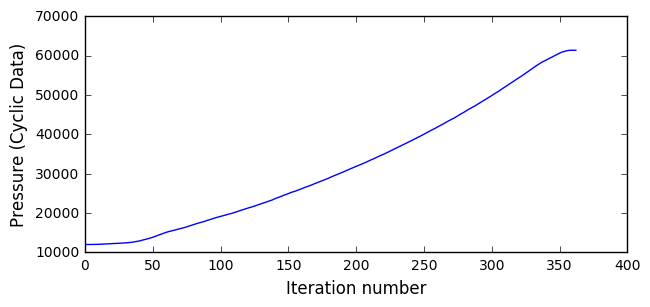

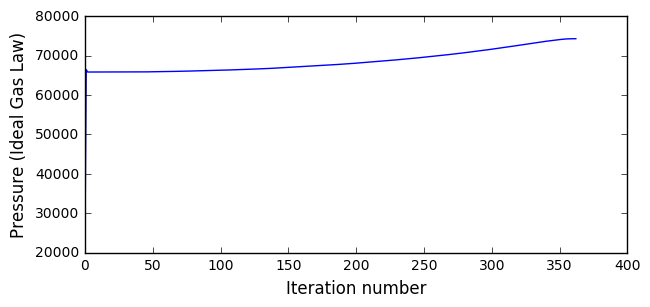

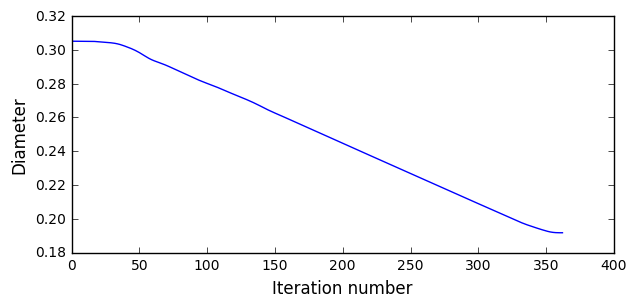

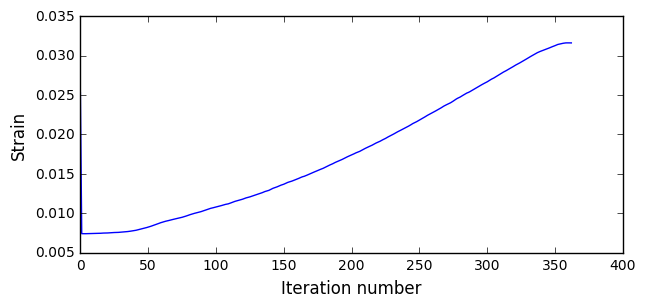

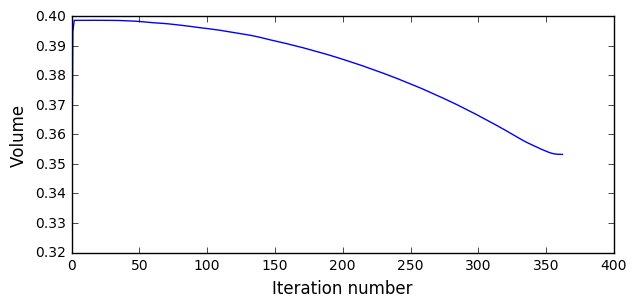

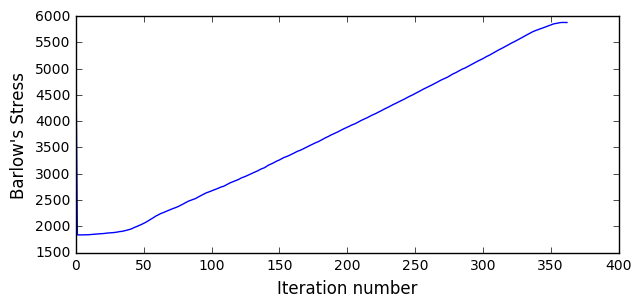

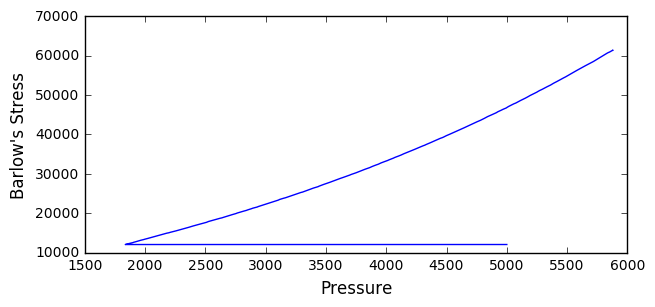

In [21]:
CreateGraphs(range(len(P_red)),P_red,"Pressure (Cyclic Data)","Iteration number",1)
CreateGraphs(range(len(P_ideal)),P_ideal,"Pressure (Ideal Gas Law)","Iteration number",2)
CreateGraphs(range(len(d_red)),d_red,"Diameter","Iteration number",3)
CreateGraphs(range(len(epsa_red)),epsa_red,"Strain","Iteration number",4)
CreateGraphs(range(len(V_red)),V_red,"Volume","Iteration number",5)
CreateGraphs(range(len(sig_b_red)),sig_b_red,"Barlow's Stress","Iteration number",6)
CreateGraphs(sig_b_red,P_red,"Barlow's Stress","Pressure",7)


In [22]:
#Import Single Cycle Burst Data:
Cyclic_Time,Cyclic_Void,Cyclic_Pressure = CyclicBagData()

#cut off starting values before max
void_start,pressure_start = zip(*[[Cyclic_Void[i], Cyclic_Pressure[i]] for i in range(len(Cyclic_Void)) if Cyclic_Void[i]<Cyclic_Void[getIndex(Cyclic_Void,1)]]) 
#cut off final value after min, final single cycle void list
void_final,pressure_final = zip(*[[void_start[i], pressure_start[i]] for i in range(len(void_start)) if void_start[i]>void_start[getIndex(Cyclic_Void,2)]]) 